In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [46]:
data = pd.read_csv('../data/model_data/spatial_df/Lassa_spatialdataset_201219separateyears_labconfirmed.csv')
data.dropna(inplace=True)

In [47]:
data

,LGA,Year,admin1Name,Cases,Cases_SuspectedUnconfirmed,Reports_All,Any_Confirmed_Cases,Source,NumDiagCentres,LabDist,...,TotalPop2015_PropUrban,ImprovedHousingPrev_PopWeighted,Cropland_prop_ESA2015,Agri_prop_ESA2015,Urb_prop_ESA2015,Forest_prop_ESA2015,PovertyProp_Mean,PovertyProp_PopWeighted,Hospital_TravelTime,AllHealthFacility_TravelTime
0,Aba North,2012,Abia,0,0,0,0,WER,2,223.150573,...,1.000000,0.768702,0.106061,0.151515,0.848485,0.0,0.334344,0.304860,12.473343,1.109442
1,Aba North,2013,Abia,1,0,1,1,WER,2,223.150573,...,1.000000,0.768702,0.106061,0.151515,0.848485,0.0,0.334344,0.304860,12.473343,1.109442
2,Aba North,2014,Abia,0,0,0,0,WER,2,223.150573,...,1.000000,0.768702,0.106061,0.151515,0.848485,0.0,0.334344,0.304860,12.473343,1.109442
3,Aba North,2015,Abia,0,0,0,0,WER,2,223.150573,...,1.000000,0.768702,0.106061,0.151515,0.848485,0.0,0.334344,0.304860,12.473343,1.109442
4,Aba North,2016,Abia,0,0,0,0,WER,2,223.150573,...,1.000000,0.768702,0.106061,0.151515,0.848485,0.0,0.334344,0.304860,12.473343,1.109442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6187,Zuru,2015,Kebbi,0,0,0,0,WER,2,530.311527,...,0.428594,0.181525,0.957888,0.975668,0.006417,0.0,0.716060,0.702661,46.583141,33.178921
6188,Zuru,2016,Kebbi,0,2,2,0,WER,2,530.311527,...,0.428594,0.181525,0.957888,0.975668,0.006417,0.0,0.716060,0.702661,46.583141,33.178921
6189,Zuru,2017,Kebbi,0,0,0,0,SitRep_1,3,361.242164,...,0.428594,0.181525,0.957888,0.975668,0.006417,0.0,0.716060,0.702661,46.583141,33.178921
6190,Zuru,2018,Kebbi,0,0,0,0,SitRep_2,4,361.242164,...,0.428594,0.181525,0.957888,0.975668,0.006417,0.0,0.716060,0.702661,46.583141,33.178921


In [48]:
data.dropna(inplace=True)

# Creating LGA names set and then assigning them their indices as values
lga_names = set(data['LGA'])
lga_replace_dict = {value: i for i, value in enumerate(lga_names)}

# Creating Year names set and then assigning them their indices as values
year_names = set(data['Year'])
year_replace_dict = {value: i for i, value in enumerate(year_names)}

# Creating Admin names set and then assigning them their indices as values
administration_names = set(data['admin1Name'])
administration_replace_dict = {value: i for i, value in enumerate(administration_names)}

# Creating Source names set and then assigning them their indices as values
source_names = set(data['Source'])
source_replace_dict = {value: i for i, value in enumerate(source_names)}

# replaces values for string values in dataset
data = data.replace({'LGA':lga_replace_dict, 
                     'Year': year_replace_dict,
                     'admin1Name': administration_replace_dict,
                     'Source': source_replace_dict})

ignore_norm_cols_array = ["AgriProp_ESA", "UrbanProp_ESA", "ForestProp_ESA", "TempMonthlyCoefv_201118_NOAA",
                     "TotalPop2015_PropUrban", "ImprovedHousingPrev_PopWeighted", "Cropland_prop_ESA2015",
                     "Agri_prop_ESA2015", "Urb_prop_ESA2015", "Forest_prop_ESA2015", "PovertyProp_Mean",
                     "PovertyProp_PopWeighted"]
# Normalize the data
for heading in data.columns:  
  if heading not in ignore_norm_cols_array:
    data[heading] = ( data[heading] - ( min(data[heading]) ) ) / ( max(data[heading]) - min(data[heading]) )

# Remove these columns
data = data.loc[:, ~data.columns.isin(['Cases', 'Cases_SuspectedUnconfirmed', 'Source', 'x', 'y', 'Reports_All'])]

In [49]:
x = data.iloc[:, data.columns != 'Any_Confirmed_Cases']
y = data.iloc[:, data.columns == 'Any_Confirmed_Cases']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [50]:
clf = RandomForestClassifier(criterion='gini',
                            max_depth=8,
                            min_samples_split=10,
                            random_state=5)

In [51]:
clf.fit(x_train, y_train)

/var/folders/9m/twj41p7s67qflftmzl1wbt_w0000gn/T/ipykernel_39007/3292451027.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


RandomForestClassifier(max_depth=8, min_samples_split=10, random_state=5)

In [52]:
clf.feature_importances_

array([0.00984058, 0.03793609, 0.01876828, 0.03657434, 0.07598729,
       0.06388928, 0.02898491, 0.01863216, 0.02662065, 0.02592531,
       0.01455239, 0.01811219, 0.01712165, 0.02454338, 0.02159464,
       0.05884493, 0.02155921, 0.02768269, 0.03206538, 0.02732871,
       0.01548758, 0.02577302, 0.018001  , 0.01844827, 0.0155307 ,
       0.01105995, 0.03175749, 0.01868187, 0.02449567, 0.0410107 ,
       0.01421314, 0.02036085, 0.01049063, 0.01213755, 0.01608102,
       0.0174201 , 0.03010871, 0.02968646, 0.01110468, 0.01158656])

In [53]:
y_pred = clf.predict(x_test)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [54]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1469,    3],
       [  62,   14]])

In [55]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9580103359173127

In [56]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, x_train, y_train, cv=10)

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y wa

array([0.94408602, 0.94623656, 0.95268817, 0.9483871 , 0.95474138,
       0.94827586, 0.94827586, 0.94612069, 0.95689655, 0.94396552])

In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      1531
         1.0       0.18      0.82      0.30        17

    accuracy                           0.96      1548
   macro avg       0.59      0.89      0.64      1548
weighted avg       0.99      0.96      0.97      1548



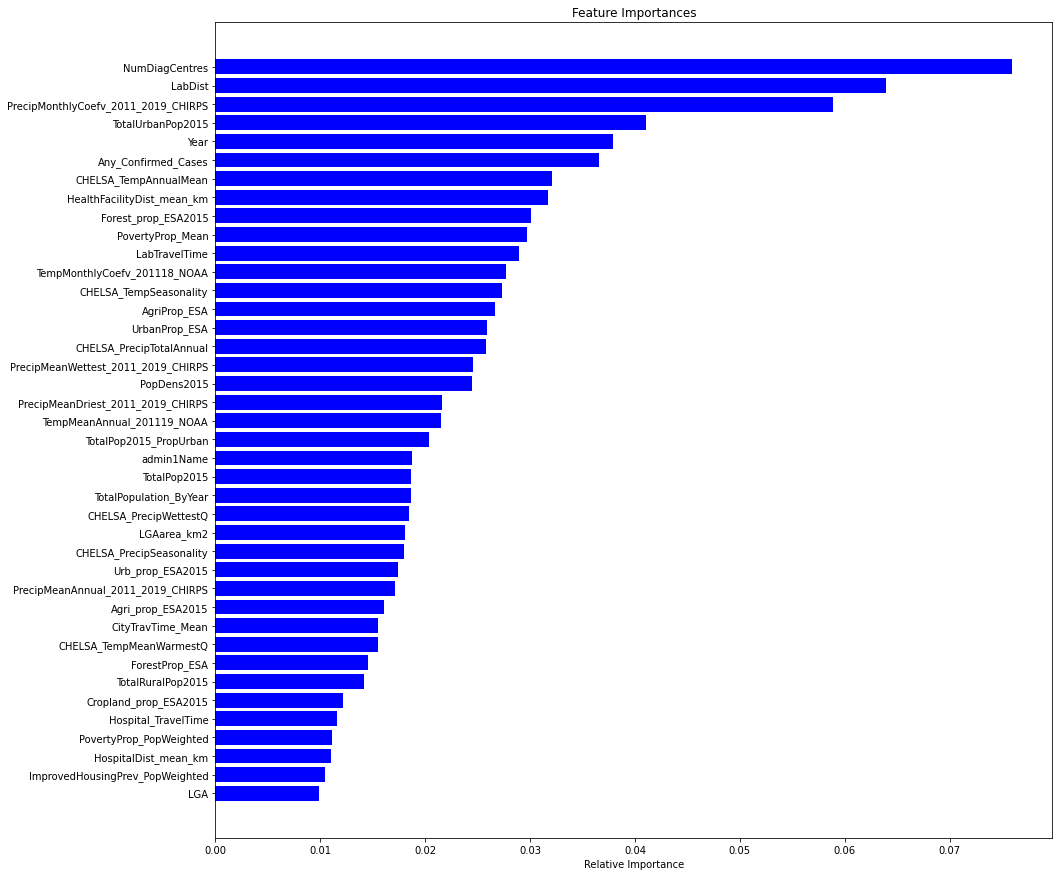

In [68]:
features = data.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(15, 15))

ax.set_title("Feature Importances")
ax.barh(range(len(indices)), importances[indices], color='b', align='center')
ax.set_yticks(range(len(indices)), [features[i] for i in indices])
ax.set_xlabel('Relative Importance')
plt.show()

In [74]:
from sklearn.metrics import roc_curve
yer = clf.predict_proba(x_test)
y_pred_proba = clf.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

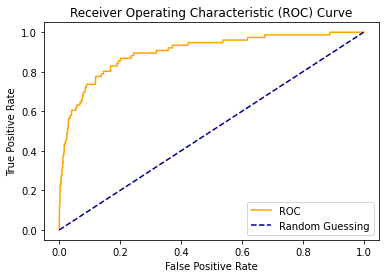

In [71]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()